In [2]:
import geopandas as gpd

<Axes: >

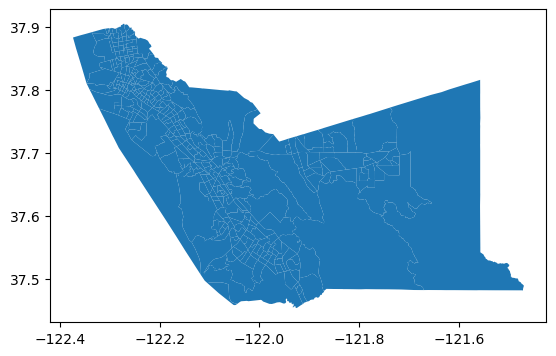

In [4]:
gpd.read_file("../../data/clean/alameda_tracts.geojson").plot()

<Axes: >

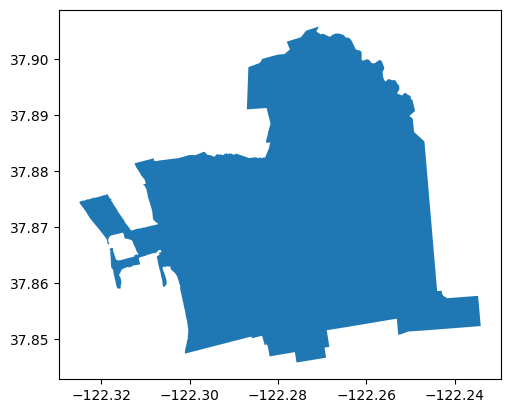

In [3]:
gpd.read_file("../../data/clean/berkeley_boundary.geojson").plot()

<Axes: >

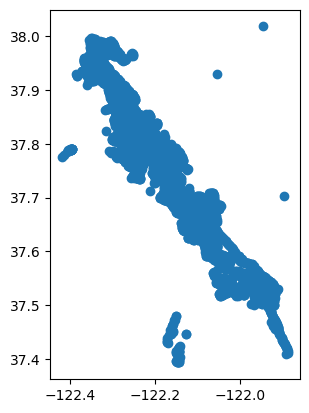

In [5]:
gpd.read_file("../../data/clean/ac_stops.geojson").plot()